# **CS 470 Assignment 2**
### 3. Comparison of MLP and CNN
#### In this assignment, you will compare two models ( MLP & CNN)
#### MLP Model (Solution) from assignment 1 on CIFAR-10 Dataset




# Download the data


In [10]:
!wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xzvf cifar-10-python.tar.gz
!rm cifar-10-python.tar.gz 
!pip install scipy

--2022-10-07 16:32:12--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  46.7MB/s    in 3.5s    

2022-10-07 16:32:16 (45.8 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
import pickle as pickle
import numpy as np
import os
from matplotlib.pyplot import imread

def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = pickle.load(f, encoding='latin1')
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)    
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte

#Load the data

In [12]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the MLP classifier.   
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = '/content/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape the data
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


####*In* this work, fully-connected (linear) layers are used, i.e. the layers can be defined as $f(x) = Wx + b$ where $W$ is the weight matrix of the layer, $x$ is its input, and $b$ is the bias. The ReLU function is essentially defined as $f(x) = \max(0, x)$.


In [13]:
def sigmoid(x):
  return 1./(1.+np.exp(-x))

class MLP(object):
  """
  A multi-layer fully-connected neural network has an input dimension of
  d, a hidden layer dimension of h, and performs classification over c classes.
  You must train the network with a softmax loss function and L1 regularization on the
  weight matrices. The network uses a LeakyReLU nonlinearity after the first fully
  -connected layer.

  The network has the following architecture:

  Input - Linear layer - LeakyReLU - Linear layer - Softmax

  The outputs of the network are the labels for each class.
  """

  def __init__(self, input_size, hidden_size, output_size, std=1e-4):
    """
    An initialization function

    Parameters
    ----------
    input_size: integer
        the dimension d of the input data.                          
    hidden_size: integer
        the number of neurons h in the hidden layer.               
    output_size: integer
        the number of classes c.                                   
    activation: string
        activation method name
    std: float
        standard deviation
    """
    # w1: weights for the first linear layer                                    
    # b1: biases for the first linear layer                                     
    # w2: weights for the second linear layer                                   
    # b2: biases for the second linear layer                                    

    self.params = {}
    self.params['w1'] = std * np.random.randn(input_size, hidden_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['w2'] = std * np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros(output_size)

    self.leaky_relu_c = 0.01
    self.activation_method = ['ReLU','LeakyReLU','SWISH'].index(activation)
    print("Selected using "+['ReLU','LeakyReLU','SWISH'][self.activation_method])
      

  def forward_pass(self, x, w1, b1, w2, b2):
    """
    A forward pass function

    Returns
    -------    
    out: 

    cache: 

    """
    h1     = None  # the activation after the first linear layer
    y1, y2 = None, None  # outputs from the first & second linear layers

    #############################################################################
    # PLACE YOUR CODE HERE                                                      #
    #############################################################################
    # TODO: Design the fully-connected neural network and compute its forward
    #       pass output, 
    #        Input - Linear layer - LeakyReLU - Linear layer.
    #       You have use predefined variables above

    y1 = np.dot(x,w1) + b1

    if self.activation_method == 0:
      # ReLU    
      h1 = np.maximum(y1, 0) 
    elif self.activation_method == 1:
      # Leaky ReLU    
      h1 = np.maximum(self.leaky_relu_c*y1, y1) 
    else:
      # SWISH
      h1 = y1 * sigmoid(y1) 

    y2 = np.dot(h1,w2) + b2

    #  END OF YOUR CODE                             
    #############################################################################
    
    out   = y2
    cache = (y1, h1) # intermediate values

    return out, cache


  def softmax_loss(self, x, y):
    """
    Compute the loss and gradients for a softmax classifier

    Returns
    -------    
    loss: 

    dx: 


    """
    #############################################################################
    # PLACE YOUR CODE HERE                                                      #
    #############################################################################
    # TODO: Compute the softmax classification loss and its gradient.           #
    # The softmax loss is also known as cross-entropy loss.                     #
    p    = np.exp(x-np.max(x, axis=1, keepdims=True)) # for stable softmax
    summ = np.sum(p, axis=1, keepdims=True)
    p    /= summ
    n    = len(x)
    loss = -np.sum( np.log(p[range(n),y]) ) / n

    dx = p.copy()
    dx[range(n),y]-=1
    dx /= n
    #  END OF YOUR CODE                             
    #############################################################################

    return loss, dx


  def backward_pass(self, dY2_dLoss, x, w1, y1, h1, w2):
    """
    A backward pass function

    Returns
    -------    
    grads: 

    
    """
    grads = {}

    #############################################################################
    # PLACE YOUR CODE HERE                                                      #
    #############################################################################
    # TODO: Compute the backward pass, computing the derivatives of the weights #
    # and biases. Store the results in the grads dictionary. For example,       #
    # the gradient on W1 should be stored in grads['w1'] and be a matrix of same#
    # size                                                                      #

    #without regularization
    grads['w2'] = np.dot(h1.T,dY2_dLoss)
    grads['b2'] = np.sum(dY2_dLoss, axis=0)

    if self.activation_method == 0:
      # ReLU    
      dY1_dLoss = np.dot(dY2_dLoss,w2.T)*(h1>0)
    elif self.activation_method == 1:
      # Leaky ReLU    
      dH1_dLoss = np.dot(dY2_dLoss,w2.T)
      inb = np.zeros(h1.shape)+self.leaky_relu_c
      inb[h1>0]=1
      dY1_dLoss = dH1_dLoss * inb
    else:
      # SWISH
      dH1_dLoss = np.dot(dY2_dLoss,w2.T)    
      swish_y1 = y1 * sigmoid(y1)
      dY1_dH1 = swish_y1 + sigmoid(y1)*(1-swish_y1)
      dY1_dLoss = dH1_dLoss * dY1_dH1

    grads['w1'] = np.dot(x.T,dY1_dLoss)
    grads['b1'] = np.sum(dY1_dLoss, axis=0)

    #  END OF YOUR CODE                             
    #############################################################################
    
    return grads


  def loss(self, x, y=None, regular=0.0, enable_margin=False):
    """
    A loss function that returns the loss and gradients of the fully-connected 
    neural network. This function requires designing forward and backward passes.
    
    If y is None, it returns a matrix labelsof shape (n, c) where labels[i, c] 
    is the label score for class c on input x[i]. Otherwise, it returns a tuple
    of loss and grads.

    Parameters
    ----------
    x:  matrix     
        an input data of shape (n, d). Each x[i] is a training sample.
    y:  vector     
        a vector of training labels. Each y[i] is an integer in the range 
        0 <= y[i] < c. y[i] is the label for x[i]. If it is passed then we
        return the loss and gradients.
    regular: float
        regularization strength.
    enable_margin: Bool
        enable to use soft-margin softmax
    
    Returns
    -------    
    loss: 
        Loss (data loss and regularization loss) for this batch of training 
        samples.
    grads: 
        Dictionary mapping parameter names to gradients of those parameters with
        respect to the loss function; has the same keys as self.params.
    """
    # Variables
    n, d   = x.shape # input dimensions
    w1, b1 = self.params['w1'], self.params['b1']
    w2, b2 = self.params['w2'], self.params['b2']
    h1     = None  # the activation after the first linear layer
    y1, y2 = None, None  # outputs from the first & second linear layers

    # Compute the forward pass
    out, cache = self.forward_pass(x,w1,b1,w2,b2)
    y2       = out
    (y1, h1) = cache

    # If the targets are not given then jump out, we're done
    if y is None:
      return y2

    # Compute the loss
    loss, dY2_dLoss = self.softmax_loss(y2, y)

    # Compute the backward pass
    grads = self.backward_pass(dY2_dLoss, x, w1, y1, h1, w2)

    #############################################################################
    # (OPTION) PLACE YOUR CODE HERE                                                      #
    #############################################################################
    # TODO: Implement weight regularization 
    #loss += 0.5 * regular * np.sum(w1**2)
    #loss += 0.5 * regular * np.sum(w2**2)

    #add regularization effect
    #grads['w2'] += regular * w2    
    #grads['w1'] += regular * w1    
    #  END OF YOUR CODE                             
    #############################################################################

    return loss, grads


  def train(self, x, y, x_v, y_v,
            eta=1e-3, lamdba=0.95,
            regular=1e-5, num_iters=50,
            batch_size=100, verbose=False):
    """
    Train this neural network using stochastic gradient descent.

    Inputs:
    - x: A numpy array of shape (n, d) giving training data.
    - y: A numpy array f shape (n,) giving training labels; y[i] = C means that
      x[i] has label C, where 0 <= C < c.
    - x_v: A numpy array of shape (n_v, d) giving validation data.
    - y_v: A numpy array of shape (n_v,) giving validation labels.
    - eta: Scalar giving learning rate for optimization.
    - lamdba: Scalar giving factor used to decay the learning rate
      after each epoch.
    - regular: Scalar giving regularization strength.
    - num_iters: Number of steps to take when optimizing.
    - batch_size: Number of training examples to use per step.
    - verbose: boolean; if true print progress during optimization.
    """
    num_train = x.shape[0]
    iterations_per_epoch = max(num_train / batch_size, 1)

    # Use Stochastic Gradient Descent (SGD) to optimize the parameters in 
    # self.model
    loss_history = []
    train_acc_history = []
    val_acc_history = []

    for it in range(num_iters):
      x_batch = None
      y_batch = None

      #########################################################################
      # PLACE YOUR CODE HERE                                                  #
      #########################################################################
      # TODO: Create a random minibatch of training data and labels, storing  #
      # them in x_batch and y_batch respectively.                             #

      idx = np.random.choice(num_train,batch_size,replace=True)
      x_batch = x[idx]
      y_batch = y[idx]

      #  END OF YOUR CODE                             
      #########################################################################

      # Compute loss and gradients using the current minibatch
      loss, grads = self.loss(x_batch, y=y_batch, regular=regular)
      loss_history.append(loss)

      #########################################################################
      # PLACE YOUR CODE HERE                                                  #
      #########################################################################
      # TODO: Update the parameters of the network stored in self.params by   #
      # using the gradients in the grads dictionary. For that, use stochastic #
      # gradient descent.                                                     #

      self.params['w1'] += -eta * grads['w1']
      self.params['w2'] += -eta * grads['w2']
      self.params['b1'] += -eta * grads['b1']
      self.params['b2'] += -eta * grads['b2']

      #  END OF YOUR CODE                             
      #########################################################################

      if verbose and it % 100 == 0:
        print('The #iteration %d / %d: loss %f' % (it, num_iters, loss))

      # Every epoch, check train and val accuracy and decay learning rate.
      if it % iterations_per_epoch == 0:
        # Check accuracy
        train_acc = (self.predict(x_batch) == y_batch).mean()
        val_acc = (self.predict(x_v) == y_v).mean()
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        # Decay learning rate
        eta *= lamdba

    return {
      'loss_history': loss_history,
      'train_acc_history': train_acc_history,
      'val_acc_history': val_acc_history,
    }

  def predict(self, x):
    """
    Use the trained weights of this MLP network to predict labels for
    data points. For each data point we predict labels for each of the C
    classes, and assign each data point to the class with the highest label 
    score.

    Inputs:
    - x: A numpy array of shape (n, d) giving n d-dimensional data points to
      classify.

    Returns:
    - y_pr: A numpy array of shape (n,) giving predicted labels for each of
      the elements of x. For all i, y_pred[i] = c means that x[i] is predicted
      to have class C, where 0 <= C < c.
    """
    y_pr = None

    ###########################################################################
    # PLACE YOUR CODE HERE                                                    #
    ###########################################################################
    # TODO: Implement the predict function                                    #
    out, _ = self.forward_pass(x, 
                               self.params['w1'], 
                               self.params['b1'],
                               self.params['w2'],
                               self.params['b2'],
                              )

    y_pr = np.argmax(out, axis=1)

    # END OF YOUR CODE                           
    ###########################################################################

    return y_pr


# Train a model
To train our model, we will use SGD with momentum. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

In [24]:
np.random.seed(1)
input_size = 32 * 32 * 3
hidden_size = 64 
num_classes = 10
activation = 'ReLU' # Select one in [ReLU, LeakyReLU, SWISH]
net_mlp = MLP(input_size, hidden_size, num_classes) 

# Train the network
stats = net_mlp.train(X_train, y_train, X_val, y_val,
            num_iters=12250, batch_size=200,
            eta=1e-3, lamdba=0.95,
            regular=0.5, verbose=True)

# Predict on the validation set
val_acc = (net_mlp.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)


Selected using ReLU
The #iteration 0 / 12250: loss 2.302574
The #iteration 100 / 12250: loss 1.988004
The #iteration 200 / 12250: loss 1.687347
The #iteration 300 / 12250: loss 1.632330
The #iteration 400 / 12250: loss 1.600027
The #iteration 500 / 12250: loss 1.590055
The #iteration 600 / 12250: loss 1.491295
The #iteration 700 / 12250: loss 1.443806
The #iteration 800 / 12250: loss 1.527687
The #iteration 900 / 12250: loss 1.556785
The #iteration 1000 / 12250: loss 1.420031
The #iteration 1100 / 12250: loss 1.454261
The #iteration 1200 / 12250: loss 1.294955
The #iteration 1300 / 12250: loss 1.289042
The #iteration 1400 / 12250: loss 1.334560
The #iteration 1500 / 12250: loss 1.304052
The #iteration 1600 / 12250: loss 1.282855
The #iteration 1700 / 12250: loss 1.402484
The #iteration 1800 / 12250: loss 1.311082
The #iteration 1900 / 12250: loss 1.277986
The #iteration 2000 / 12250: loss 1.317799
The #iteration 2100 / 12250: loss 1.246767
The #iteration 2200 / 12250: loss 1.151044
The

# Visualization


You have to plot the loss function and the accuracies on the training and validation sets.Also, visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

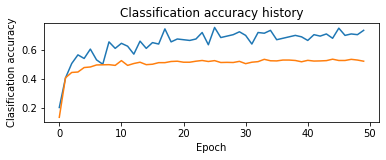

In [25]:
import matplotlib.pyplot as plt
# Plot the loss function and train / validation accuracies
def showStats(stats):
   
    plt.subplot(2, 1, 2)
    plt.plot(stats['train_acc_history'], label='train')
    plt.plot(stats['val_acc_history'], label='val')
    plt.title('Classification accuracy history')
    plt.xlabel('Epoch')
    plt.ylabel('Clasification accuracy')
    plt.show()
    
showStats(stats)

# CNN Model 


In [16]:
"""

USE CNN Model from Problem 2 in CNN_problem_2.ipynb

"""


'\n\nUSE CNN Model from Problem 2 in CNN_problem_2.ipynb\n\n'

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified
Device: cpu
Number of trainable parameters: 62006
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------
[epoch 1] loss: 0.00

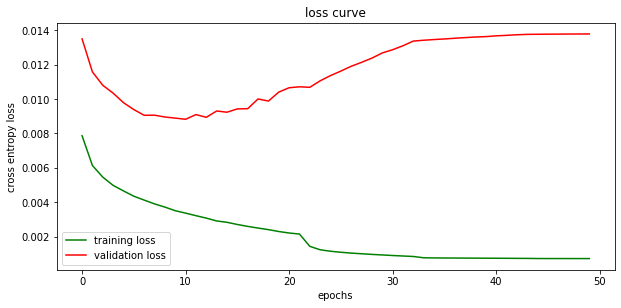

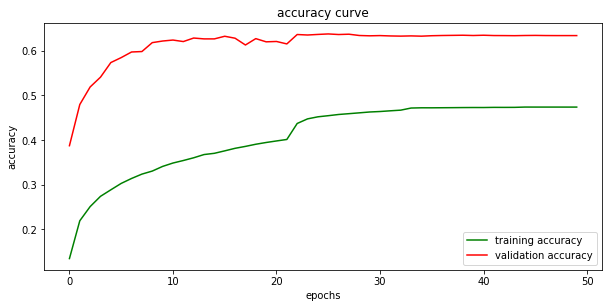

In [17]:
#Importing all libraries
import os
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import PIL
from PIL import Image
from torchvision import datasets


train_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_set, val_set = torch.utils.data.random_split(dataset, [40000, 10000])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False, num_workers=8)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False, num_workers=8)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

import matplotlib.pyplot as plt
import numpy as np


import torch.nn as nn
import torch.nn.functional as F

# Problem 2: Implementing your own CNN
# a. Convolution and MaxPooling layers


class CNN_Max(nn.Module):
  """
  A convolutional neural network (CNN). In this CNN object, we will use following
  dimensions:

  input_size: the dimension d of the input data.                        
  hidden_size: the number of neurons h in the hidden layer.             
  output_size: the number of classes c, which is 10 in our task          
  """
  def __init__(self):
    """
    An initialization function. This object of network is a simple feed-forward 
    network. It takes an input to pass to muitiple layers. Then, provide the 
    output. The layers are initialized after their creation. 

    In this problem, we will use following set of parameters building a CNN/

    conv: convolutional kernel size, as an example 3 by 3                          
    pool: pooling kernel-size, as an example 2 by 2                                
    fc: fully-connected layer which uses affine operation y=Wx+b              

    Parameters
    ----------
    N/A
    """
    super(CNN_Max, self).__init__()

    #############################################################################
    # PLACE YOUR CODE HERE                                                      #
    #############################################################################
    # the image is 32 * 32 * 3
    self.conv1 = nn.Conv2d(3, 6, 5)          # output shape 28 * 28 * 6
    self.pool = nn.MaxPool2d(2, 2)           # output shape 14 * 14 * 6 
    self.conv2 = nn.Conv2d(6, 16, 5) 
    #self.dropout = nn.Dropout(0.25)                    # output shape 10 * 10 * 16
                                        # after applying pool again 5 * 5 * 16, flatten to 400
    self.fc1 = nn.Linear(16 * 5 * 5, 120)  # we apply relu activation after l1 and l2
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    #self.batch_1 = nn.BatchNorm2d(6)
    #self.batch_2 = nn.BatchNorm2d(16) 
 
    # END OF YOUR CODE                                                          #
    #############################################################################
   

  def forward(self, x):
    """
    A forward pass function. Using the pre-defined network modules, we can here 
    build a model designing its structure. 

    Parameters
    ---------- 
    x: matrix  
      an input data of shape (3, d, d), where d is the dimension of the input 
      image. Note that we use RGB images so channels are 3.
  
    Returns
    ---------- 
    out:     
      an output data given x.

    """
    #############################################################################
    # PLACE YOUR CODE HERE                                                      #
    ############################################################################# 
    out = self.conv1(x)
    #out = self.batch_1(out)
    out = self.pool(out)
    out = self.conv2(out)
    #out = self.batch_2(out)
    out = self.pool(out)
    #out = self.dropout(out)
    out = out.view(out.shape[0], -1)                    #torch.flatten??????????
    out = F.relu(self.fc1(out))
    out = F.relu(self.fc2(out))
    out = self.fc3(out)

    # END OF YOUR CODE                                                          #
    #############################################################################

    return out

# create a CNN object
net = CNN_Max()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)
net.to(device)

num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Number of trainable parameters:", num_params)

from torchsummary import summary
summary(net,(3,32,32))
import torch.optim as optim

"""

 You have to define the loss, for that please use cross entropy loss      
 Also, you must implement optimizer called SGD with Momentum. You can decide the momentum value by yourself to get the highest test accuracy.                           

"""

#############################################################################
# PLACE YOUR CODE HERE                                                      #
############################################################################# 

learning_rate = 0.01
momentum = 0.9

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = learning_rate, momentum=momentum)  


#############################################################################
#                              END OF YOUR CODE                             #
#############################################################################
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, min_lr=0)

loss_hist, acc_hist = [], []
loss_hist_val, acc_hist_val = [], []

for epoch in range(50):
  running_loss = 0.0
  correct = 0
  for data in train_loader:
    batch, labels = data
    batch, labels = batch.to(device), labels.to(device)

    """

    First, set the gradients to zero. Then obtain predictions from your CNN   
    model. After that, pass into loss to calculate the difference between the 
    prediction and labels. Next, you have to compute the gradients with       
    respect to the tensor.  


    """
#############################################################################
# PLACE YOUR CODE HERE                                                      #
############################################################################# 
    optimizer.zero_grad()
    # aug =torch.nn.Sequential(transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),transforms.RandomHorizontalFlip(p=0.5))

    # aug_batch = aug(batch)
    # batch = torch.cat((aug_batch, batch), 0)
    # labels = torch.cat((labels, labels), 0)

    outputs = net(batch)
    loss = criterion(outputs, labels)
    loss.backward()  

#############################################################################
#                              END OF YOUR CODE                             #
#############################################################################
    optimizer.step()

    # compute training statistics
    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum().item()
    running_loss += loss.item()

  avg_loss = running_loss / (2 * len(train_set))
  avg_acc = correct / (2 * len(train_set))
  loss_hist.append(avg_loss)
  acc_hist.append(avg_acc)

  # validation statistics
  net.eval()
  with torch.no_grad():
    loss_val = 0.0
    correct_val = 0
    for data in val_loader:
      batch, labels = data
      batch, labels = batch.to(device), labels.to(device)
      outputs = net(batch)
      loss = criterion(outputs, labels)
      _, predicted = torch.max(outputs, 1)
      correct_val += (predicted == labels).sum().item()
      loss_val += loss.item()
    avg_loss_val = loss_val / len(val_set)
    avg_acc_val = correct_val / len(val_set)
    loss_hist_val.append(avg_loss_val)
    acc_hist_val.append(avg_acc_val)
  net.train()

  scheduler.step(avg_loss_val)
  print('[epoch %d] loss: %.5f accuracy: %.4f val loss: %.5f val accuracy: %.4f' % (epoch + 1, avg_loss, avg_acc, avg_loss_val, avg_acc_val))

import matplotlib.pyplot as plt

# epoch = 50
# plt.figure(figsize=(10,10))
# plt.subplot(2,1,1)
# plt.plot(range(epoch), loss_hist, 'g', label='training loss')
# plt.plot(range(epoch), loss_hist_val, 'r', label = 'validation loss')
# plt.xlabel('epochs')
# plt.ylabel('cross entropy loss')
# plt.title('loss curve')
# plt.legend(loc=0)
# plt.show()

# plt.figure(figsize=(10,10))
# plt.subplot(2,1,2)
# plt.plot(range(epoch), acc_hist, 'g', label='training accuracy')
# plt.plot(range(epoch), acc_hist_val, 'r', label = 'validation accuracy')
# plt.xlabel('epochs')
# plt.ylabel('accuracy')
# plt.title('accuracy curve')
# plt.legend(loc=0)
# plt.show()                               



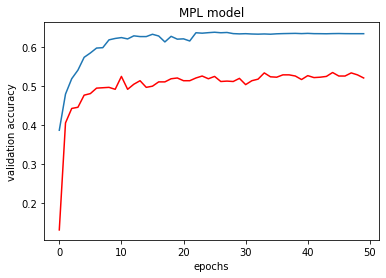

In [26]:
"""

Visualize a plot of validation accuracy curves from
the two models

"""

###########################################################################
# PLACE YOUR CODE HERE                                                    #
###########################################################################
     
# loss_hist, loss_hist_val, acc_hist, acc_hist_val # for the cnn model
# for the fc layer we have stats['val_acc_history']
# we have to draw validation accuracy curves

plt.plot()
plt.xlabel("epochs")
plt.ylabel("validation accuracy")
plt.plot(acc_hist_val)
plt.title("CNN model")
plt.ylabel("validation accuracy")
plt.plot(stats['val_acc_history'], '-r')
plt.title("MPL model")
plt.show()







# END OF YOUR CODE                           
###########################################################################